In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas_ta
from ta.momentum import StochasticOscillator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

C:\Users\daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas_ta\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
#pip install xgboost

In [5]:
#pip install openpyxl


In [6]:
#pip install pandas-ta

In [7]:
df = yf.download("EURUSD=X", interval="1d", period="10y")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [8]:
def remove_outliers_iqr(df, column, multiplier=2.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    df = df.copy()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan
    df[column] = df[column].fillna(method='ffill')
    return df

In [9]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2015-07-08,1.100994,1.109010,1.097502,1.100994,0
2015-07-09,1.107101,1.111620,1.102290,1.107236,0
2015-07-10,1.106305,1.122000,1.105620,1.106305,0
2015-07-13,1.112904,1.119759,1.100770,1.112904,0
2015-07-14,1.099046,1.107400,1.096850,1.098515,0


In [10]:
df = df.drop('Volume', axis=1)  # axis=1 means column
df

Price,Close,High,Low,Open
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,
2015-07-08,1.100994,1.109010,1.097502,1.100994
2015-07-09,1.107101,1.111620,1.102290,1.107236
2015-07-10,1.106305,1.122000,1.105620,1.106305
2015-07-13,1.112904,1.119759,1.100770,1.112904
2015-07-14,1.099046,1.107400,1.096850,1.098515
...,...,...,...,...
2025-07-02,1.180554,1.181000,1.174922,1.180554
2025-07-03,1.180025,1.181335,1.172086,1.180025


In [11]:
df = df.reset_index()


In [12]:
df.columns = df.columns.get_level_values(0)

In [13]:
df

Price,Date,Close,High,Low,Open
0,2015-07-08,1.100994,1.109010,1.097502,1.100994
1,2015-07-09,1.107101,1.111620,1.102290,1.107236
2,2015-07-10,1.106305,1.122000,1.105620,1.106305
3,2015-07-13,1.112904,1.119759,1.100770,1.112904
4,2015-07-14,1.099046,1.107400,1.096850,1.098515
...,...,...,...,...,...
2599,2025-07-02,1.180554,1.181000,1.174922,1.180554
2600,2025-07-03,1.180025,1.181335,1.172086,1.180025
2601,2025-07-04,1.177149,1.178689,1.175668,1.177149
2602,2025-07-07,1.178078,1.179009,1.171907,1.178078


In [14]:
# df = pd.read_excel(r"C:\Users\daksh\Downloads\company_data.xlsx")
# print(df.head())

In [15]:
df.columns = df.columns.str.lower()
df


Price,date,close,high,low,open
0,2015-07-08,1.100994,1.109010,1.097502,1.100994
1,2015-07-09,1.107101,1.111620,1.102290,1.107236
2,2015-07-10,1.106305,1.122000,1.105620,1.106305
3,2015-07-13,1.112904,1.119759,1.100770,1.112904
4,2015-07-14,1.099046,1.107400,1.096850,1.098515
...,...,...,...,...,...
2599,2025-07-02,1.180554,1.181000,1.174922,1.180554
2600,2025-07-03,1.180025,1.181335,1.172086,1.180025
2601,2025-07-04,1.177149,1.178689,1.175668,1.177149
2602,2025-07-07,1.178078,1.179009,1.171907,1.178078


In [16]:
for col in ['open', 'high', 'low', 'close']:
    df = remove_outliers_iqr(df, col)

C:\Users\daksh\AppData\Local\Temp\ipykernel_13108\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
C:\Users\daksh\AppData\Local\Temp\ipykernel_13108\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
C:\Users\daksh\AppData\Local\Temp\ipykernel_13108\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
C:\Users\daksh\AppData\Local\Temp\ipykernel_13108\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')


In [17]:
print(df.describe())

Price                           date        close         high          low  \
count                           2604  2604.000000  2604.000000  2604.000000   
mean   2020-07-06 06:38:42.580645120     1.118073     1.121560     1.114561   
min              2015-07-08 00:00:00     0.959619     0.967006     0.954016   
25%              2018-01-07 06:00:00     1.083201     1.086472     1.080264   
50%              2020-07-07 12:00:00     1.114274     1.117584     1.110821   
75%              2023-01-04 06:00:00     1.156009     1.159915     1.152834   
max              2025-07-08 00:00:00     1.251001     1.255808     1.245051   
std                              NaN     0.053089     0.052890     0.053254   

Price         open  
count  2604.000000  
mean      1.118051  
min       0.959619  
25%       1.083236  
50%       1.114268  
75%       1.155926  
max       1.251267  
std       0.053079  


In [18]:
print(df['close'].dtype)

float64


In [19]:
df.columns



Index(['date', 'close', 'high', 'low', 'open'], dtype='object', name='Price')

In [20]:
def add_indicators(df):
    df = df.copy()
    
    # Simple Moving Averages
    for window in [14, 50, 100, 200]:
        df[f'SMA_{window}'] = ta.trend.SMAIndicator(close=df['close'], window=window).sma_indicator()
    
    # RSI 14
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
    
    # MACD (12,26,9)
    macd = ta.trend.MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()

    return df

In [21]:
# Add swing high and trend line features
df.loc[:, 'swing_high'] = (df['high'] > df['high'].rolling(window=5).max().shift(1))
high_points = df[df['swing_high']][['date', 'high']]
print(f"Number of swing highs: {len(high_points)}")
if len(high_points) > 0:
    high_points['index'] = high_points.index
    X_trend = high_points['index'].values.reshape(-1, 1)
    y_trend = high_points['high'].values
    trend_model = LinearRegression().fit(X_trend, y_trend)
    df.loc[:, 'trend_line'] = trend_model.predict(df.index.values.reshape(-1, 1))
    df.loc[:, 'distance_to_trend'] = df['close'] - df['trend_line']
    df.loc[:, 'breakout'] = (df['close'] > df['trend_line']).astype(int)
else:
    X_trend = df.index.values.reshape(-1, 1)
    y_trend = df['close'].values
    trend_model = LinearRegression().fit(X_trend, y_trend)
    df.loc[:, 'trend_line'] = trend_model.predict(X_trend)
    df.loc[:, 'distance_to_trend'] = df['close'] - df['trend_line']
    df.loc[:, 'breakout'] = (df['close'] > df['trend_line']).astype(int)
    print("No swing highs detected; using linear trend on all closes")
df = df.dropna()

Number of swing highs: 622


In [22]:
df = add_indicators(df)

In [23]:
df['return_1d'] = df['close'].pct_change()
df['return_5d'] = df['close'].pct_change(5)
df['volatility_5d'] = df['close'].rolling(5).std()
df['sma_ratio'] = df['SMA_14'] / df['SMA_50']


In [24]:
df

Price,date,close,high,low,open,swing_high,trend_line,distance_to_trend,breakout,SMA_14,...,SMA_200,RSI_14,MACD,MACD_Signal,Stoch_K,Stoch_D,return_1d,return_5d,volatility_5d,sma_ratio
0,2015-07-08,1.100994,1.109010,1.097502,1.100994,False,1.158130,-0.057135,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-09,1.107101,1.111620,1.102290,1.107236,False,1.158106,-0.051005,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005547,NaN,NaN,NaN
2,2015-07-10,1.106305,1.122000,1.105620,1.106305,False,1.158083,-0.051778,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000719,NaN,NaN,NaN
3,2015-07-13,1.112904,1.119759,1.100770,1.112904,False,1.158059,-0.045155,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005965,NaN,NaN,NaN
4,2015-07-14,1.099046,1.107400,1.096850,1.098515,False,1.158036,-0.058990,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.012452,NaN,0.005471,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,2025-07-02,1.180554,1.181000,1.174922,1.180554,False,1.097346,0.083208,1,1.161353,...,1.085877,73.773429,0.010818,0.008706,93.525312,90.052172,0.001558,0.016646,0.005505,1.018143
2600,2025-07-03,1.180025,1.181335,1.172086,1.180025,False,1.097322,0.082702,1,1.162782,...,1.086197,73.092970,0.011218,0.009209,92.138705,91.459399,-0.000448,0.009971,0.005013,1.018551
2601,2025-07-04,1.177149,1.178689,1.175668,1.177149,False,1.097299,0.079850,1,1.164316,...,1.086526,69.351526,0.011174,0.009602,84.607747,90.090588,-0.002437,0.006780,0.003136,1.019182
2602,2025-07-07,1.178078,1.179009,1.171907,1.178078,False,1.097275,0.080803,1,1.165955,...,1.086821,69.887906,0.011086,0.009899,87.041258,87.929236,0.000789,0.004547,0.001394,1.019835


In [25]:
df['future_return'] = df['close'].pct_change(periods=3).shift(-3)
df['Target'] = (df['future_return'] > 0.001).astype(int)
df = df.dropna().reset_index(drop=True)


In [26]:
df

Price,date,close,high,low,open,swing_high,trend_line,distance_to_trend,breakout,SMA_14,...,MACD,MACD_Signal,Stoch_K,Stoch_D,return_1d,return_5d,volatility_5d,sma_ratio,future_return,Target
0,2016-04-12,1.141292,1.146400,1.135306,1.141214,True,1.153476,-0.012184,0,1.131957,...,0.008351,0.007655,83.751038,80.401392,0.000867,0.002100,0.001655,1.013841,-0.012521,0
1,2016-04-13,1.138498,1.139302,1.127400,1.138602,False,1.153452,-0.014954,0,1.133414,...,0.008032,0.007730,74.398619,80.554640,-0.002448,0.000262,0.001599,1.014304,-0.007469,0
2,2016-04-14,1.127904,1.129400,1.123601,1.128006,False,1.153429,-0.025524,0,1.134207,...,0.006845,0.007553,40.073541,66.074399,-0.009305,-0.011042,0.005349,1.014673,0.002658,1
3,2016-04-15,1.127002,1.131800,1.124758,1.126507,False,1.153405,-0.026404,0,1.134993,...,0.005766,0.007196,34.019536,49.497232,-0.000800,-0.009140,0.006969,1.015249,0.007952,1
4,2016-04-18,1.129995,1.133200,1.127497,1.130097,False,1.153382,-0.023387,0,1.135688,...,0.005093,0.006775,28.044904,34.045993,0.002656,-0.009040,0.006518,1.015589,0.000452,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,2025-06-27,1.169221,1.175088,1.168429,1.169221,True,1.097416,0.071806,1,1.154601,...,0.008565,0.007320,84.407594,86.417879,0.000725,0.015586,0.007737,1.014107,0.009692,1
2398,2025-06-30,1.172745,1.177163,1.170905,1.172745,True,1.097392,0.075353,1,1.156740,...,0.009215,0.007699,87.917025,85.380466,0.003014,0.019702,0.005501,1.015396,0.006207,1
2399,2025-07-01,1.178717,1.183026,1.176775,1.178717,True,1.097369,0.081348,1,1.159238,...,0.010096,0.008178,88.714180,87.012933,0.005092,0.016219,0.006399,1.017099,-0.001330,0
2400,2025-07-02,1.180554,1.181000,1.174922,1.180554,False,1.097346,0.083208,1,1.161353,...,0.010818,0.008706,93.525312,90.052172,0.001558,0.016646,0.005505,1.018143,-0.002097,0


In [27]:
features = ['Stoch_K', 'SMA_100', 'SMA_14', 'SMA_50', 'MACD', 'RSI_14', 'Stoch_D', 'MACD_Signal', 'SMA_200',
            'return_1d', 'return_5d', 'volatility_5d', 'sma_ratio']

In [28]:
X = df[features]
y = df["Target"]


In [29]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False, random_state=42)

In [31]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.1,# L1 regularization (for sparsity)
    reg_lambda=1.0 )

In [32]:
#Hyperparameter Tuning with GridSearchCV and TimeSeriesSplit on training set
param_grid = {
    'n_estimators': [150,200],
    'max_depth': [3],
    'min_child_weight': [25,20,30],  # Regularization parameter for XGBoost
    'learning_rate': [0.05,0.1,],
    'gamma': [0.1,0.2,0.3],  # Minimum loss reduction for split
    'reg_alpha':[0,0.1,0.5],
    'reg_lambda':[1,5,10]
}
tscv = TimeSeriesSplit(n_splits=3)
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                        param_grid, cv=tscv,
                        scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best params:", xgb_grid.best_params_)
best_xgb_model = xgb_grid.best_estimator_

Best params: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 20, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1}


C:\Users\daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:59:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
best_xgb_model.fit(X_train, y_train)  # Train the model


C:\Users\daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:59:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [34]:
# Threshold tuning
probs = best_xgb_model.predict_proba(X_test)[:, 1]
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.3, 0.65, 0.01):
    preds = (probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print("Best Threshold:", best_thresh)
y_pred = (probs > best_thresh).astype(int)

Best Threshold: 0.3


In [35]:
print("Training Accuracy:", accuracy_score(y_train, best_xgb_model.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Training Accuracy: 0.7600208224882874
Testing Accuracy: 0.5114345114345115
F1 Score: 0.648729446935725
              precision    recall  f1-score   support

           0       0.69      0.12      0.20       251
           1       0.49      0.94      0.65       230

    accuracy                           0.51       481
   macro avg       0.59      0.53      0.42       481
weighted avg       0.60      0.51      0.41       481

Confusion Matrix:
 [[ 29 222]
 [ 13 217]]


In [36]:
print("Train F1:", f1_score(y_train, best_xgb_model.predict(X_train)))
print("Test F1:", f1_score(y_test, best_xgb_model.predict(X_test)))

Train F1: 0.6791927627000696
Test F1: 0.5461254612546126


In [39]:
# Predict signals from test set
y_pred = best_xgb_model.predict(X_test)

# Get only the test portion of df (last 481 rows)
test_df = df.iloc[-len(X_test):].copy()

# Assign signals to that smaller DataFrame
test_df['Signal'] = y_pred

# Add Date column (if not already present)
test_df['Date'] = test_df.index

# Export the signal data
test_df[['date', 'open', 'high', 'low', 'close', 'Signal']].to_csv("signals.csv", index=False)

print("✅ signals.csv exported successfully.")


✅ signals.csv exported successfully.


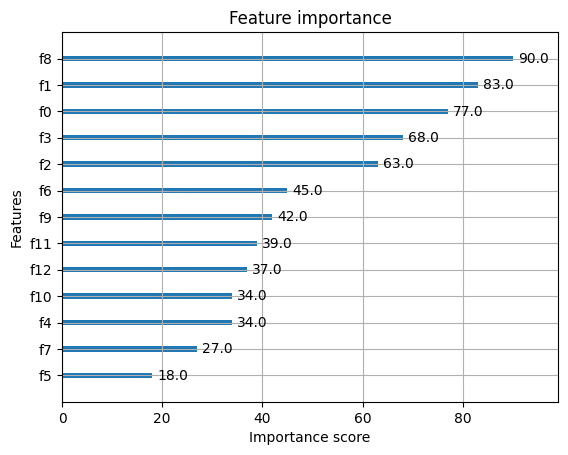

In [34]:
# Feature selection
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel

plot_importance(best_xgb_model)
selector = SelectFromModel(best_xgb_model, threshold='median', prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [36]:
# Backtesting
def backtest(df, signals, initial=10000, spread=0.0001):
    df = df.copy()
    df['Signal'] = signals
    df['Returns'] = df['close'].pct_change()
    df['Strategy'] = df['Returns'] * df['Signal'].shift(1)
    df['Strategy'] -= (df['Signal'] != df['Signal'].shift(1)).astype(int) * spread
    df['Cumulative Market'] = (1 + df['Returns']).cumprod() * initial
    df['Cumulative Strategy'] = (1 + df['Strategy']).cumprod() * initial
    return df
df_test = df.iloc[-len(X_test):].copy()
df_test= backtest(df_test,y_pred)
cumulative_returns = backtest(df_test, y_pred)

C:\Users\daksh\AppData\Local\Temp\ipykernel_18152\1945789504.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


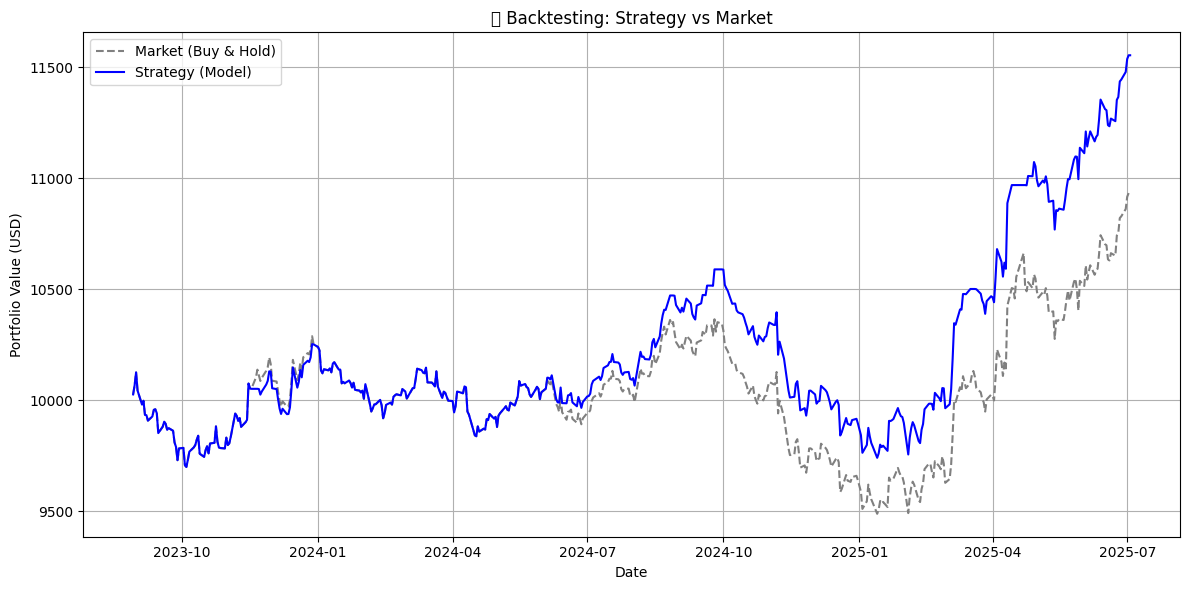

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['date'], df_test['Cumulative Market'], label='Market (Buy & Hold)', color='gray', linestyle='--')
plt.plot(df_test['date'], df_test['Cumulative Strategy'], label='Strategy (Model)', color='blue')

plt.title('📈 Backtesting: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


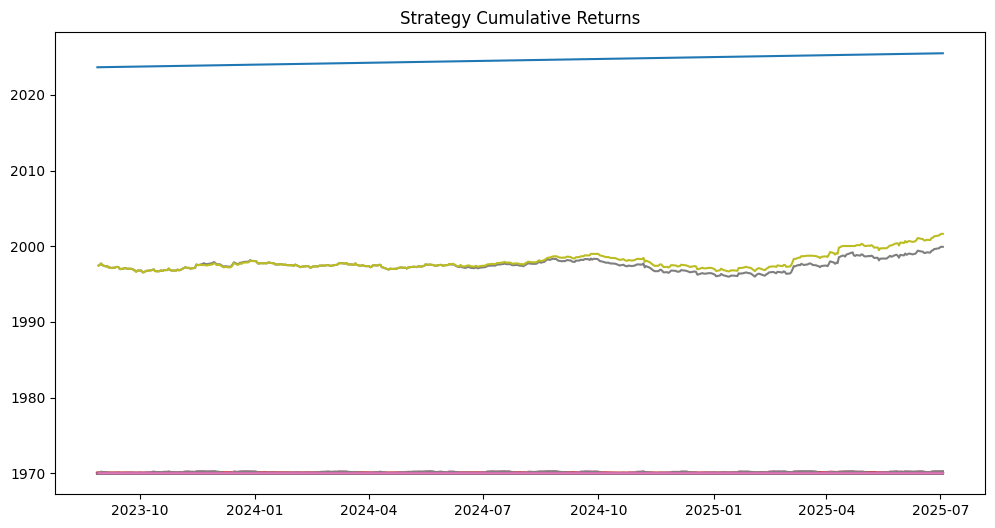

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(df_test['date'], cumulative_returns)
plt.title('Strategy Cumulative Returns')
plt.show()

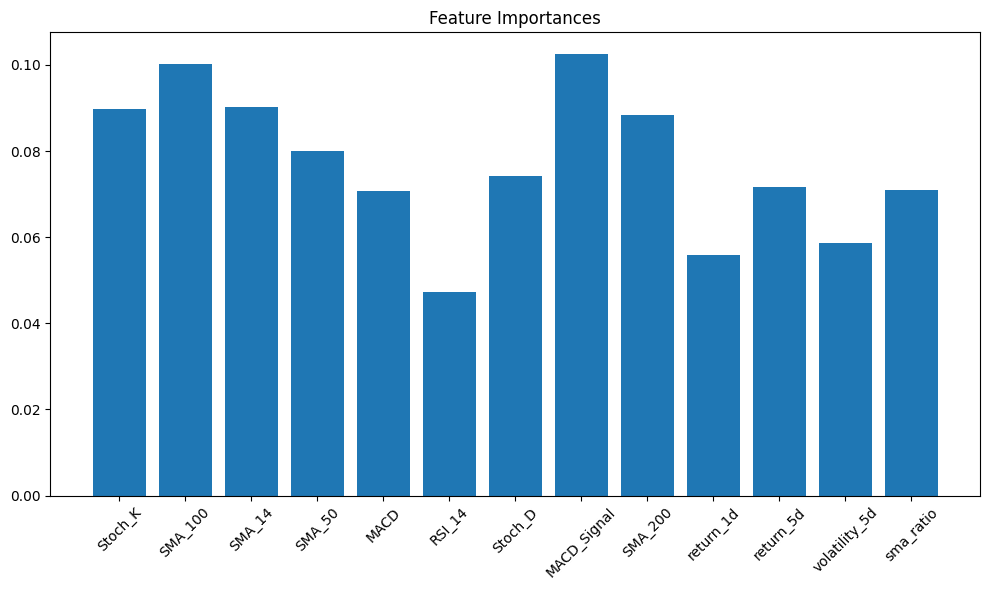

In [39]:
importances = best_xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xticks(rotation=45)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# train_preds = best_xgb_model.predict(X_train)
# test_preds = best_xgb_model.predict(X_test)
# train_acc = accuracy_score(y_train, train_preds)
# test_acc = accuracy_score(y_test, test_preds)
# print(f"✅ Training Accuracy: {train_acc:.4f}")
# print(f"✅ Testing Accuracy: {test_acc:.4f}")

In [ ]:
# # Step 1: Get feature importances from the trained model
# importances = best_xgb_model.feature_importances_

# # Step 2: Create a DataFrame
# feature_importance_df = pd.DataFrame({
#     'Feature': features,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)

# # Step 3: Print nicely
# print("🔍 Feature Importances:")
# print(feature_importance_df.to_string(index=False))

# # Step 4: Remove features with very low importance (threshold can be adjusted)
# threshold = 0.01
# selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

# print("\n✅ Selected Features (Importance > 0.01):", selected_features)

# # Step 5 (Optional): Update X to only use selected features
# X = df[selected_features]


In [ ]:
# #Hyperparameter Tuning with GridSearchCV and TimeSeriesSplit
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_leaf': [1, 3, 5],
#     'min_samples_split': [2, 10, 20]
# }
# tscv = TimeSeriesSplit(n_splits=5)
# grid = GridSearchCV(RandomForestClassifier(random_state=42),
#                     param_grid, cv=tscv,
#                     scoring='accuracy', n_jobs=-1)
# grid.fit(X_scaled, y)
# print("Best params:", grid.best_params_)
# best_model = grid.best_estimator_

In [ ]:
# # Split data into train and test for final evaluation (last split as test)
# tscv = TimeSeriesSplit(n_splits=5)
# for train_index, test_index in tscv.split(X_scaled):
#     if train_index[-1] < test_index[0]:  # Ensure last split is used for test
#         X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         break

In [ ]:
# train_preds = best_model.predict(X_train)
# test_preds = best_model.predict(X_test)
# train_acc = accuracy_score(y_train, train_preds)
# test_acc = accuracy_score(y_test, test_preds)
# print(f"✅ Training Accuracy: {train_acc:.4f}")
# print(f"✅ Testing Accuracy: {test_acc:.4f}")

In [ ]:
# # Detailed Metrics
# print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))
# print("Classification Report:\n", classification_report(y_test, test_preds))

In [ ]:
# model = RandomForestClassifier(
#     n_estimators=200,
#     max_depth = 20,
#     min_samples_split = 10,
#     min_samples_leaf=5,
#     random_state=42)
# model.fit(X_train, y_train)


In [ ]:
# model.fit(X_train, y_train)
# train_acc = model.score(X_train, y_train)
# test_preds = model.predict(X_test)
# test_acc = accuracy_score(y_test, test_preds)
# print(f"Initial Training Accuracy: {train_acc:.4f}")
# print(f"Initial Testing Accuracy: {test_acc:.4f}")

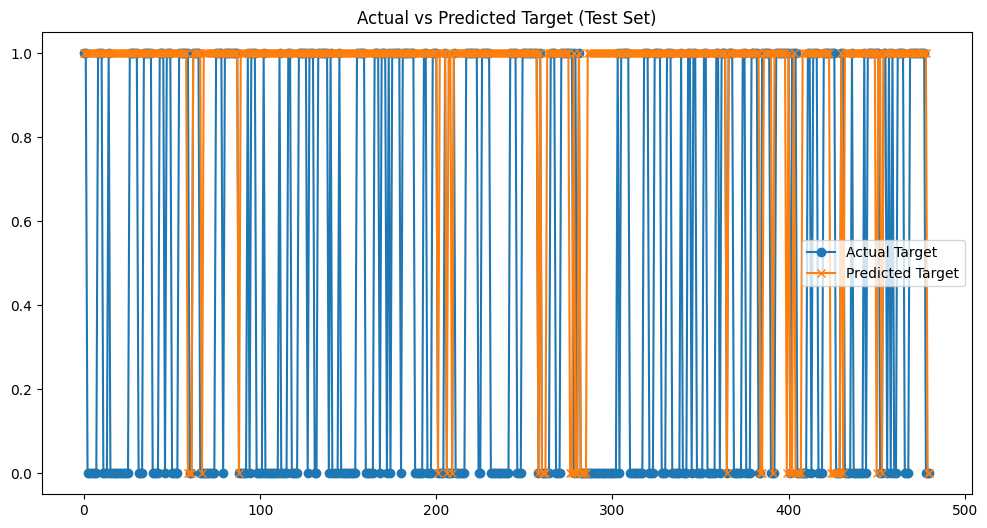

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Target', marker='o')
plt.plot(y_pred, label='Predicted Target', marker='x')
plt.title('Actual vs Predicted Target (Test Set)')
plt.legend()
plt.show()

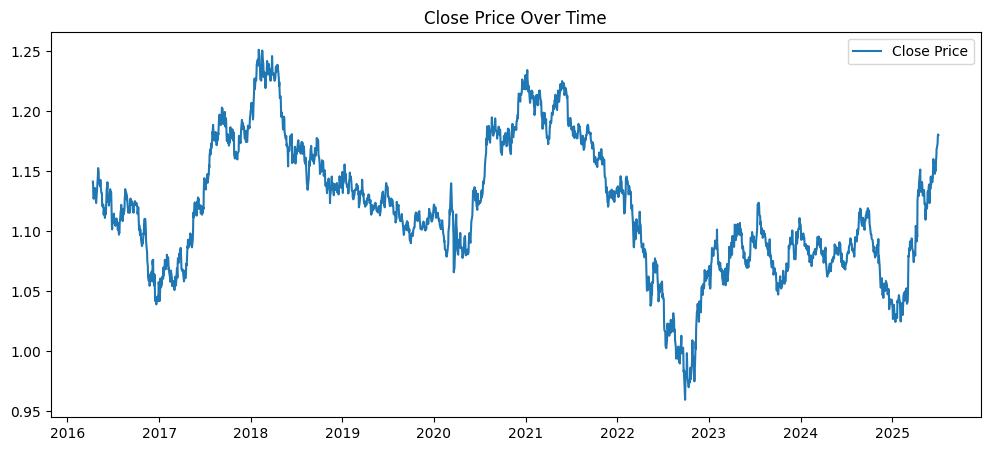

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title('Close Price Over Time')
plt.legend()
plt.show()

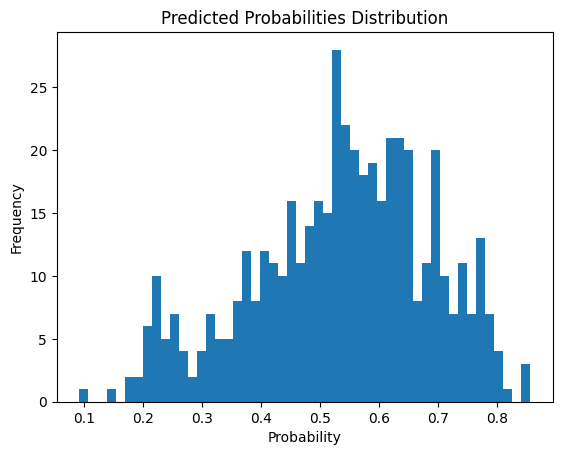

In [42]:
import matplotlib.pyplot as plt

plt.hist(probs, bins=50)
plt.title("Predicted Probabilities Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


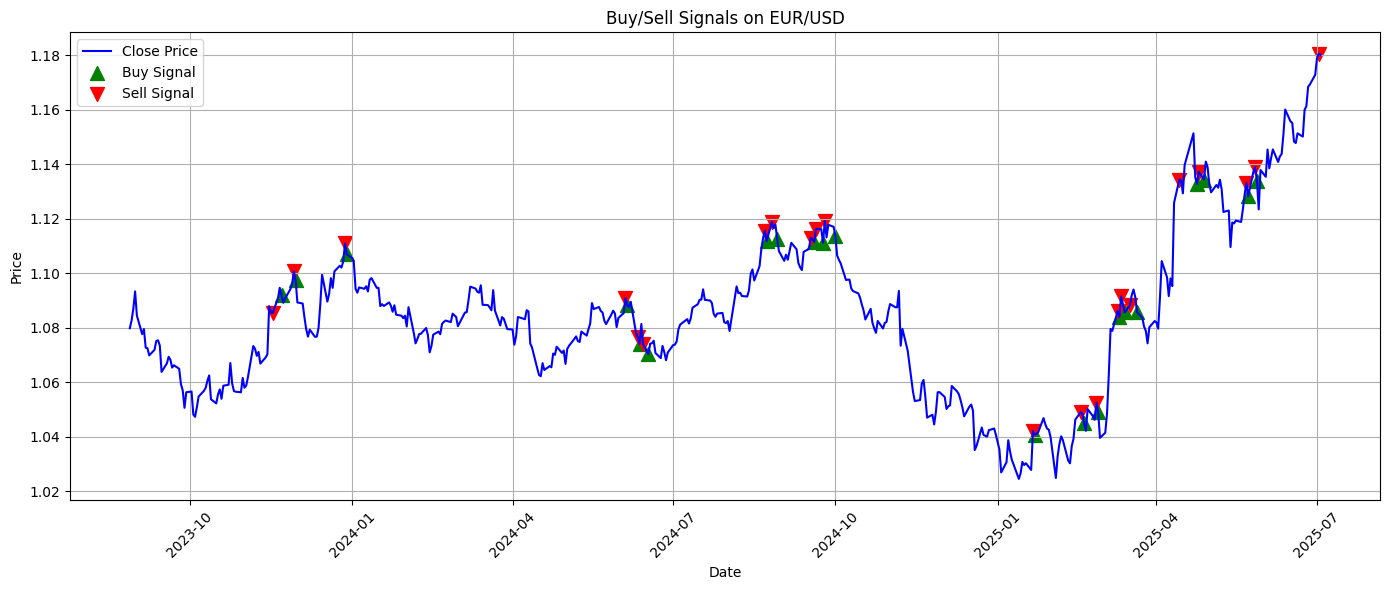

In [43]:
import matplotlib.dates as mdates

# Prepare the signal DataFrame
df_signals = df.iloc[-len(y_test):].copy().reset_index(drop=True)
df_signals['Signal'] = y_pred.flatten()
df_signals['Price'] = df_signals['close']

# Identify signals
buy_signals = df_signals[(df_signals['Signal'] == 1) & (df_signals['Signal'].shift(1) == 0)]
sell_signals = df_signals[(df_signals['Signal'] == 0) & (df_signals['Signal'].shift(1) == 1)]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_signals['date'], df_signals['Price'], label='Close Price', color='blue')

# Buy
plt.scatter(buy_signals['date'], buy_signals['Price'], marker='^', color='green', label='Buy Signal', s=100)

# Sell
plt.scatter(sell_signals['date'], sell_signals['Price'], marker='v', color='red', label='Sell Signal', s=100)

# Format
plt.title('Buy/Sell Signals on EUR/USD')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
df['Signal'] = best_xgb_model.predict(X_test)
df['Date'] = df.index
df[['Date', 'Open', 'High', 'Low', 'Close', 'Signal']].to_csv("signals.csv", index=False)


ValueError: Length of values (481) does not match length of index (2402)